In [145]:
from astropy.nddata import CCDData
import matplotlib.pyplot as plt
from astropy.nddata import Cutout2D
from astropy.coordinates import SkyCoord
import astropy.units as u
import numpy as np
import scipy

# ASTR 310 HW 10

### 1.  Fourier analysis of 2D images

More work with that LMC image from Lectures 18 and 21.

**a.)** Use `numpy.fft.rfft2` to construct the 2D Fourier transform of the image.  Pick two of your favorite integers $q$ and $w$ between 0 and 30; the only condition is that at least one of them must be nonzero.  If `fhat` contains your Fourier components, then set `fhat[q,w]` equal to something large, such as 10 times the maximum in `fhat`.  Then do the inverse FT and plot the result.  You should see that a spike in the Fourier components corresponds to a sine wave across the image. [7 pts]

In [146]:
img = CCDData.read("../../Labs/Lec18/lmc.ha.b20.fits", unit='1/s')

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Changed DATE-OBS from '21/11/1998' to '1998-11-21''. [astropy.wcs.wcs]


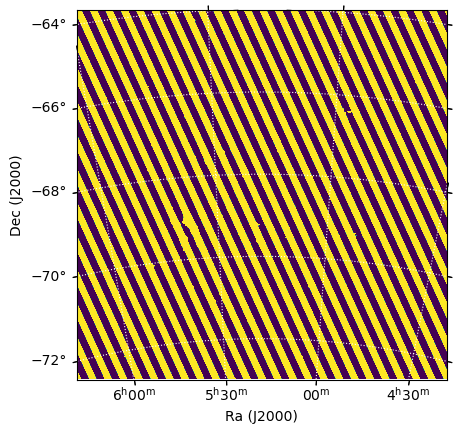

In [147]:
q = 11
w = 24
fhat = np.fft.rfft2(img.data)
fhat[q,w] = 10 * np.max(fhat)

new_img = np.fft.irfft2(fhat)
plt.subplot(projection=img.wcs)
plt.imshow(new_img, vmin=-0.3, vmax=1, origin='lower')
plt.grid(color='white', ls='dotted')
plt.xlabel("Ra (J2000)")
plt.ylabel("Dec (J2000)")

**b.)**  Again, take the 2D Fourier transform of the original image.  This time, remove all the odd-numbered Fourier components.  In other words, set `fhat[k,j] = 0` if either k or j is odd.  Transform back to real space and plot the result.  

Can you explain what happened to the image?  As a hint, you might go back to the previous part and experiment with putting your spike at `fhat[0,1]` or [0,3] or [1,0] to find out what the removed components look like.  Add your explanation as some comments in the code or a new markdown cell.

[7 pts]

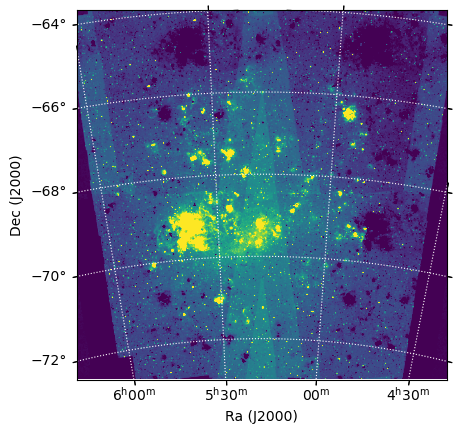

In [148]:
fhat = np.fft.rfft2(img.data)
fhat[0:-1:2, 0:-1:2] = 0

new_img = np.fft.irfft2(fhat)

plt.subplot(projection=img.wcs)
plt.imshow(new_img, vmin=-0.3, vmax=1, origin='lower')
plt.grid(color='white', ls='dotted')
plt.xlabel("Ra (J2000)")
plt.ylabel("Dec (J2000)")

The image has had all of the odd fourier components subtracted from it, leaving geometric artifacts in the image.

###  2. Image processing  -- removing background ripples

Download the file `spt_imap_ra5h30dec-55_2008_150ghz_sfl_dr1.fits` from the course web site. This is an image of part of the sky scanned by the South Pole Telescope at a frequency of 150 GHz (in the microwave band).  SPT images at this frequency are particularly good at picking up active galaxies at high redshifts, but they are also susceptible to low-level ripples in the background.  We will work on removing the ripples from the background using a Fourier filter technique.

**a.)** Use CCDData.read from astropy.nddata to read in the image and store it as a CCDData object. The image values are brightness temperatures in units of K, but you can call them unit="adu" since the units don't matter for this task.

Use Cutout2D to cut out a $4^\circ \times 4^\circ$ region centered at RA = $05^h 37^m 33^s$, Dec = $-57^\circ 03^\prime 22^{\prime\prime}$. Pass the image WCS to Cutout2D so the cutout gets a WCS.

[7 pts]

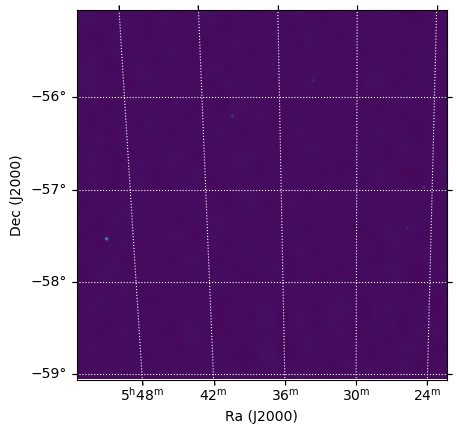

In [149]:
img = CCDData.read("spt_imap_ra5h30dec-55_2008_150ghz_sfl_dr1.fits", unit="adu")

center = SkyCoord("05h37m33s -57d03m22s")
size = [4, 4] * u.degree

cut = Cutout2D(data=img, position=center, size=size, wcs=img.wcs)

plt.subplot(projection=cut.wcs)
plt.imshow(cut.data, origin='lower')
plt.grid(color='white', ls='dotted')
plt.xlabel("Ra (J2000)")
plt.ylabel("Dec (J2000)")

**b.)** Here's the Fourier filter step.
* Construct the 2D Fourier transform of the cutout data.
* Find the $k_x$ and $k_y$ values using `fftfreq/rfftfreq` and create meshgrids from them.
* Use the meshgrids to compute the magnitude of the wavevector $|k|$ at each point in your meshgrids.
* Select all the Fourier components with $|k| < 50/N_x$, where $N_x$ is the number of columns in the cutout, and set their amplitudes to zero.
* Inverse transform to recover a filtered version of the cutout image. 

[10 pts]

**c.)** Plot the original cutout and the filtered version, using the same stretch for easy comparison.  I found that it worked well to compute the standard deviation $\sigma$ in the cutout image values and then to plot with a linear stretch between $-5\sigma$ and $5\sigma$.

If everything worked well, you should see that the Fourier filter removed those low-level ripples that look like waves in the background of the original cutout.  However, the filter also introduced rings around the bright point sources in the image.

[5 pts]

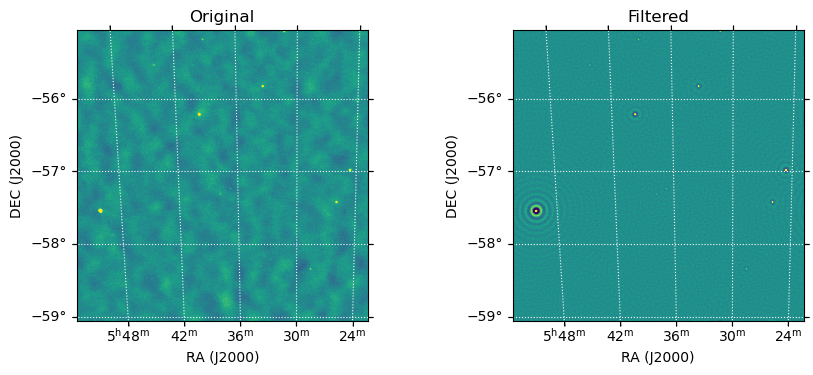

In [153]:
# fourier transform
fhat = np.fft.rfft2(cut.data)
# find kx and ky
ky = np.fft.fftfreq(cut.data.shape[0])
kx = np.fft.rfftfreq(cut.data.shape[1])

# create meshrid
xx, yy = np.meshgrid(kx, ky)

# compute magnitude of wavevector
k = (xx**2 + yy**2)**(1/2)

# select components
fhat[k < 50/cut.data.shape[1]] = 0

# inverse transform
new_img = np.fft.irfft2(fhat)

# display
fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(131, projection=cut.wcs)
ax2 = fig.add_subplot(132, projection=cut.wcs)

std1 = np.std(cut.data)
ax1.imshow(cut.data, vmin=-5*std1, vmax=5*std1, origin='lower')
ax1.grid(color='white', ls='dotted')
ax1.set_ylabel("DEC (J2000)")
ax1.set_xlabel("RA (J2000)")
ax1.set_title("Original")

std2 = np.std(new_img)
ax2.imshow(new_img, vmin=-5*std2, vmax=5*std2, origin='lower')
ax2.grid(color='white', ls='dotted')
ax2.set_ylabel("DEC (J2000)")
ax2.set_xlabel("RA (J2000)")
ax2.set_title("Filtered")
plt.subplots_adjust(wspace=0.5, hspace=0.2)

### 3.  Unsharp masking on a galaxy image.

Download the file `hst_15133_49_wfc3_uvis_f475w_idkv49_drc.fits`.  It's an HST image of a nearby galaxy, NGC 4596.  The galaxy has some dust lanes near its center, and the dust clouds make localized regions with high extinction, but it's difficult to see the structure of the dust lanes on top of the smooth galaxy bulge.  This is a classic case for unsharp masking.

**a.)**  Plot an image of the original data.  Log scaling can make a decent-looking stretch if you control vmax and vmin.  Try to show at least a few details in the structure of the galaxy.

[4 pts]

INFO: first HDU with data is extension 1. [astropy.nddata.ccddata]


Set MJD-BEG to 58328.423646 from DATE-BEG.
Set MJD-END to 58328.435081 from DATE-END'. [astropy.wcs.wcs]
/var/folders/41/_gkgvhb94wd4156zplzr4cg00000gn/T/ipykernel_89287/244537291.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(img), vmin=-0.3, vmax=0.75, origin='lower')


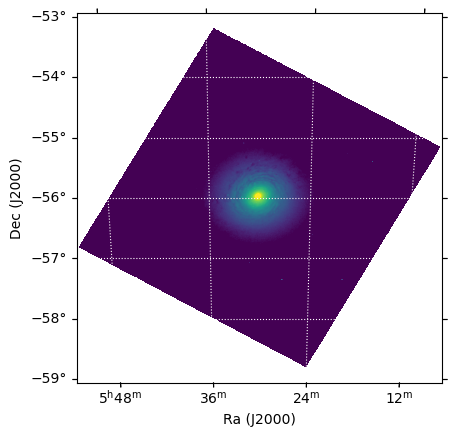

In [151]:
img = CCDData.read("hst_15133_49_wfc3_uvis_f475w_idkv49_drc.fits")
plt.subplot(projection=cut.wcs)
plt.imshow(np.log10(img), vmin=-0.3, vmax=0.75, origin='lower')
plt.grid(color='white', ls='dotted')
plt.xlabel("Ra (J2000)")
plt.ylabel("Dec (J2000)")

**b.)**  Apply a simple unsharp masking strategy to this image.  Smooth it with a Gaussian of width $\sigma,$ where reasonable values for $\sigma$ might be between 10 and 40 pixels.  Divide the original by the smoothed version.

**c.)**  Plot an image of the residuals and adjust the color scale so that you can see the dust features in the galaxy.  Hints about displaying the residuals: if the smoothing worked correctly, then most of the residual values will be near 1.

**d.)**  Try this exercise for two different smoothing widths and plot them both.

[10 pts]

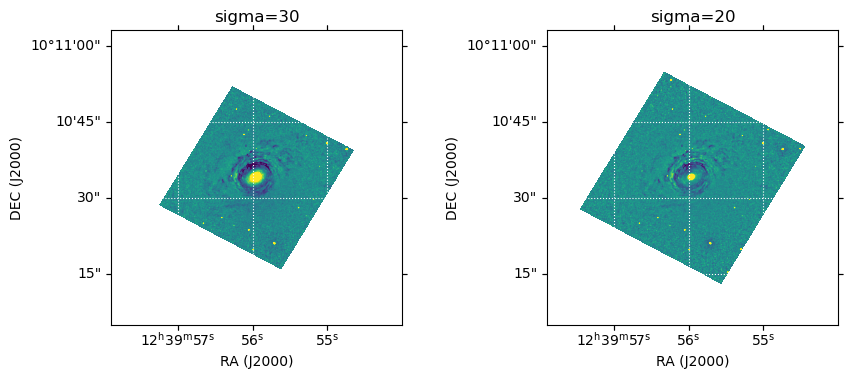

In [152]:
img_smooth_30 = scipy.ndimage.gaussian_filter(img, sigma=30)
img_smooth_20 = scipy.ndimage.gaussian_filter(img, sigma=20)
residuals_30 = img / img_smooth_30
residuals_20 = img / img_smooth_20

fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(131, projection=img.wcs)
ax2 = fig.add_subplot(132, projection=img.wcs)

ax1.imshow(residuals_30, vmin=0.8, vmax=1.2, origin='lower')
ax1.grid(color='white', ls='dotted')
ax1.set_ylabel("DEC (J2000)")
ax1.set_xlabel("RA (J2000)")
ax1.set_title("sigma=30")

ax2.imshow(residuals_20, vmin=0.8, vmax=1.2, origin='lower')
ax2.grid(color='white', ls='dotted')
ax2.set_ylabel("DEC (J2000)")
ax2.set_xlabel("RA (J2000)")
ax2.set_title("sigma=20")

plt.subplots_adjust(wspace=0.5, hspace=0.2)